In [1]:
import pandas as pd
import os
import dateutil

### Define markets

In [2]:
markets = {
    'euronx': 1,
    'lse': 2,
    'milano': 3,
    'dbx': 4,
    'mercados': 5,
    'amsterdam': 6,
    'compA': 7,
    'compB': 8,
    'xetra': 9,
    'bruxelle': 10,
    'peapme': 11 # Appears in the files but not in the given SQL database
}

### Import dataset from specified directory

In [3]:
root_dir = "../data/boursorama"

# Importing only 1000 files (testing on a small batch)
count = 0
df = pd.concat({dateutil.parser.parse(f[f.find("20"):-4]): pd.read_pickle(os.path.join(root, f)).assign(mid=markets.get(f[:f.find(" ")])) for root, dirs, files in os.walk(root_dir) for f in files if (count := count + 1) <= 10000})

df.drop("symbol", axis=1, inplace=True)

In [4]:
df

last   volume                 name  \
                           symbol                                               
2022-01-25 10:52:01.605605 AKTX        1.370(c)   211151   AKARI THERP SP ADR   
                           FLWS       22.510(c)   693145  1-800-FLOWERS.COM-A   
                           VCXA        9.800(c)    11112    10X CAP VENT RG-A   
                           VCXAU      10.150(c)     2461     10X CAP VENT UTS   
                           TXG        94.660(c)  1526408    10X GENOMICS RG-A   
...                                         ...      ...                  ...   
2022-12-16 10:12:02.052691 1rPWLNNV    0.000(c)        0            WORLDLINE   
                           1rPXFAB        6.550    43494        X-FAB SILICON   
                           1rPXPO    315.000(c)        0     SRDXPO LOGISTICS   
                           1rPZC      24.830(c)        0          ZODIAC AERO   
                           1rPZCNV    27.010(c)        0      ZODIAC AERO E17   

                                     mid  
                           symbol         
2022-01-25 10:52:01.605605 AKTX        6  
                           FLWS        6  
                           VCXA        6  
                           VCXAU       6  
                           TXG         6  
...                                  ...  
2022-12-16 10:12:02.052691 1rPWLNNV    7  
                           1rPXFAB     7  
                           1rPXPO      7  
                           1rPZC       7  
                           1rPZCNV     7  

[11496156 rows x 4 columns]

### Remove entries with NaN values

In [5]:
df.dropna(inplace=True)

### Create companies and stocks dataframes

In [6]:
# Select only one instance of each company and remove useless columns
companies = df.reset_index().drop_duplicates('symbol').drop(columns=['level_0', 'last', 'volume']).reset_index(drop=True)
companies

,symbol,name,mid
0,AKTX,AKARI THERP SP ADR,6
1,FLWS,1-800-FLOWERS.COM-A,6
2,VCXA,10X CAP VENT RG-A,6
3,VCXAU,10X CAP VENT UTS,6
4,TXG,10X GENOMICS RG-A,6
...,...,...,...
6363,SVOKU,SVN OAKS ACQ UTS 25,6
6364,FF11_DEME,DEME GROUP,7
6365,ALFUM,FILL UP MEDIA,7
6366,GBLI,GLB INDEMN GRP RG-A,6


In [7]:
# Merge the initial df with the companies df to get the company id
stocks = df.reset_index().merge(companies.assign(cid=companies.index)[['symbol', 'cid']], on='symbol', how='left')
stocks = stocks.set_index(['level_0', 'cid'])

In [8]:
# Remove useless columns
stocks = stocks.drop(columns=['symbol', 'name', 'mid'])
# Rename 'last' column to 'value'
stocks['value'] = stocks['last'].astype(str)
stocks.drop(axis=1, labels='last', inplace=True)
stocks

volume       value
level_0                    cid                      
2022-01-25 10:52:01.605605 0      211151    1.370(c)
                           1      693145   22.510(c)
                           2       11112    9.800(c)
                           3        2461   10.150(c)
                           4     1526408   94.660(c)
...                                  ...         ...
2022-12-16 10:12:02.052691 5645        0    0.000(c)
                           5316    43494       6.550
                           5646        0  315.000(c)
                           5647        0   24.830(c)
                           5648        0   27.010(c)

[11496156 rows x 2 columns]

### Extract letters from last values and create a new column with it

In [9]:
stocks['value_letter'] = stocks['value'].str.replace('[0-9\. \(\)]', "", regex=True)
stocks['value'] = stocks['value'].str.replace('\([a-zA-Z]\)| ', "", regex=True)

In [10]:
stocks.groupby('value_letter').size()

value_letter
     3561601
c    7919603
s      14952
dtype: int64

### Convert last values from string to float

In [11]:
stocks['value'] = stocks['value'].astype(float)

In [12]:
stocks.dtypes

volume            int64
value           float64
value_letter     object
dtype: object

In [13]:
stocks.sort_values('value')

,,volume,value,value_letter
level_0,cid,,,
2022-03-08 15:22:02.211616,1875,0,0.0,
2022-08-24 16:52:02.204271,5992,0,0.0,c
2022-04-28 12:52:01.609182,5533,0,0.0,
2022-02-28 15:12:01.547263,5725,100642724,0.0,
2022-03-18 16:22:02.060945,5602,0,0.0,c
...,...,...,...,...
2022-04-20 14:42:01.413816,5156,0,8750.0,
2022-05-17 12:52:02.036294,5156,0,8750.0,
2022-11-16 09:12:01.377797,5156,0,8750.0,


In [14]:
stocks.sort_index()

volume    value value_letter
level_0                    cid                               
2022-01-03 09:42:02.108157 0     321752    1.500            c
                           1     430194   23.370            c
                           2       7268    9.790            c
                           3       6135   10.330            c
                           4     383349  148.960            c
...                                 ...      ...          ...
2022-12-30 17:52:02.137557 6157       0    0.000             
                           6158       0    0.000             
                           6159  146813    0.224             
                           6242       0    0.000             
                           6243       0    0.000             

[11496156 rows x 3 columns]

In [15]:
daystocks = stocks
daystocks.index.rename(['date', 'cid'], inplace=True)
daystocks = stocks.reset_index()
daystocks['date'] = daystocks['date'].dt.date

starting = daystocks[daystocks["value_letter"] == 's']
closing = daystocks[daystocks["value_letter"] == 'c']

starting.rename(columns={"value": "open"}, inplace=True)
closing.rename(columns={"value": "close"}, inplace=True)

daystocks = daystocks.groupby(['date', 'cid']).agg(high=pd.NamedAgg(column='value', aggfunc='max'),
                                                   low=pd.NamedAgg(column='value', aggfunc='min'),
                                                   volume=pd.NamedAgg(column='volume', aggfunc='sum'),
)

daystocks = daystocks.reset_index()
daystocks = pd.merge(daystocks, starting[['open', 'date', 'cid']], on=['date', 'cid'], how='left')
daystocks = pd.merge(daystocks, closing[['close', 'date', 'cid']], on=['date', 'cid'], how='left')

daystocks[(~daystocks['open'].isna()) & (~daystocks['close'].isna()) & (daystocks['open'] != daystocks['close'])]

/home/guilalire/.local/lib/python3.10/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,date,cid,high,low,volume,open,close
3057515,2022-05-13,4321,24.50,23.460,0,24.01,23.46
3057516,2022-05-13,4321,24.50,23.460,0,24.01,23.46
3057517,2022-05-13,4321,24.50,23.460,0,24.01,23.46
3057518,2022-05-13,4321,24.50,23.460,0,24.34,23.46
3057519,2022-05-13,4321,24.50,23.460,0,24.34,23.46
...,...,...,...,...,...,...,...
6652113,2022-10-28,4605,8.98,8.635,0,8.98,8.85
6652114,2022-10-28,4605,8.98,8.635,0,8.98,8.85
6652115,2022-10-28,4605,8.98,8.635,0,8.98,8.85
6652116,2022-10-28,4605,8.98,8.635,0,8.98,8.85


---------------------------------
### Testing: Plotting the graph for one stock 

Plotting stock AKTX:


/home/guilalire/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


<Axes: xlabel='date'>

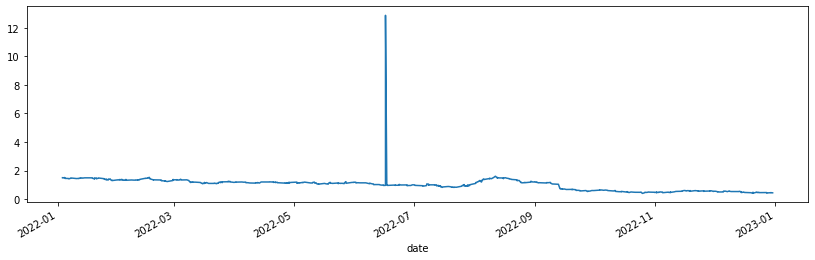

In [16]:
cid = 0
one_stock = stocks.xs(cid, level='cid')
print(f"Plotting stock {companies.iloc[cid].symbol}:") 
one_stock['value'].plot(figsize=(14,4))